In [6]:
import os
import tarfile
import requests

# --- Configuration ---
url = "https://www.cs.jhu.edu/~mdredze/datasets/sentiment/domain_sentiment_data.tar.gz"
download_filename = "domain_sentiment_data.tar.gz"
extract_dir = "/content/" # Extract directly into the main content directory
expected_data_folder = os.path.join(extract_dir, "sorted_data_acl") # The folder inside the archive

# --- Download ---
print(f"Downloading dataset from {url}...")
try:
    response = requests.get(url, stream=True)
    response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)

    with open(download_filename, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print(f"Downloaded successfully to {download_filename}")

except requests.exceptions.RequestException as e:
    print(f"Error downloading file: {e}")


# --- Extract ---
if os.path.exists(download_filename):
    print(f"\nExtracting {download_filename} to {extract_dir}...")
    try:
        with tarfile.open(download_filename, "r:gz") as tar:
            tar.extractall(path=extract_dir)
        print("Extraction complete.")

        # --- Verification ---
        if os.path.isdir(expected_data_folder):
            print(f"Verified: Folder '{expected_data_folder}' exists.")
            print("Contents of the extracted folder:")
            # Use !ls for a quick directory listing
            !ls -l /content/sorted_data_acl
            !ls -l /content/sorted_data_acl/books
        else:
            print(f"Error: Expected folder '{expected_data_folder}' not found after extraction.")

        # --- Set Data Path for Subsequent Code ---
        # This path would be used in following data loading stage
        data_path = expected_data_folder
        print(f"\nData path is set to: {data_path}")

    except tarfile.TarError as e:
        print(f"Error extracting file: {e}")
    except Exception as e:
        print(f"An unexpected error occurred during extraction: {e}")
else:
    print("Download failed, cannot extract.")


Downloaded successfully to domain_sentiment_data.tar.gz

Extracting domain_sentiment_data.tar.gz to /content/...
Extraction complete.
Verified: Folder '/content/sorted_data_acl' exists.
Contents of the extracted folder:
total 16
drwxr-xr-x 2 root root 4096 Apr 28 03:07  books
drwxr-xr-x 2 root root 4096 Apr 28 03:07  dvd
drwxr-xr-x 2 root root 4096 Apr 28 03:07  electronics
drwxr-xr-x 2 root root 4096 Apr 28 03:07 'kitchen_&_housewares'
total 2980
-rwxr-xr-x 1 34371 2167 1538092 Jan 18  2007 negative.review
-rwxr-xr-x 1 34371 2167 1510877 Jan 18  2007 positive.review

Data path is set to: /content/sorted_data_acl


NLTK resources downloaded.

--- Loading Data ---
Processing domain: books
  Attempting to load: /content/sorted_data_acl/books/positive.review
    -> Loaded 1000 positive reviews.
  Attempting to load: /content/sorted_data_acl/books/negative.review
    -> Loaded 1000 negative reviews.
  Attempting to load: /content/sorted_data_acl/books/unlabeled.review
    -> Unlabeled file not found.
Processing domain: dvd
  Attempting to load: /content/sorted_data_acl/dvd/positive.review
    -> Loaded 1000 positive reviews.
  Attempting to load: /content/sorted_data_acl/dvd/negative.review
    -> Loaded 1000 negative reviews.
  Attempting to load: /content/sorted_data_acl/dvd/unlabeled.review
    -> Loaded 34741 unlabeled reviews for potential label inference.
    -> Inferred labels for 34741 unlabeled reviews based on ratings.
Processing domain: electronics
  Attempting to load: /content/sorted_data_acl/electronics/positive.review
    -> Loaded 1000 positive reviews.
  Attempting to load: /content/

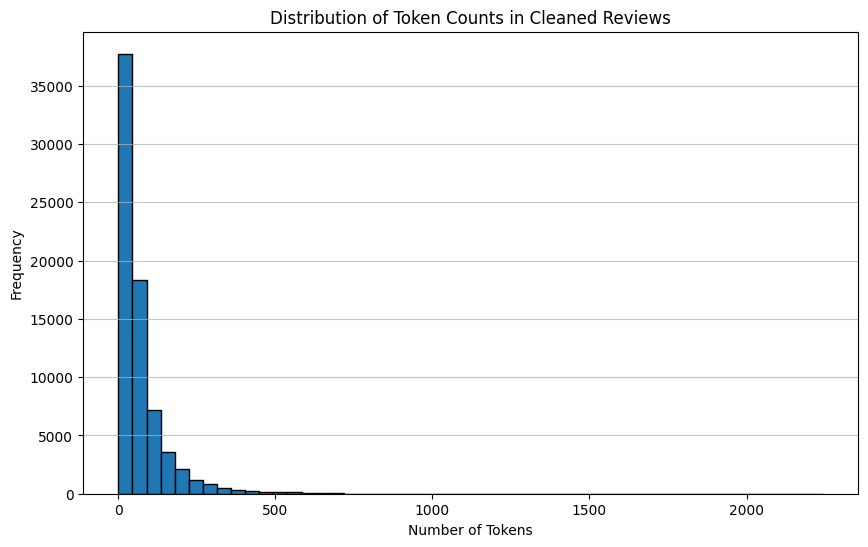


Token Count Percentiles:
  10th percentile (P10): 13
  80th percentile (P80): 100
  85th percentile (P85): 123
  90th percentile (P90): 160
  95th percentile (P95): 228

Filtering reviews: Keeping those with token count between 13 and 160 (inclusive).
Number of reviews retained for modeling: 58533 (out of 72679)
Percentage of reviews kept: 80.54%

--- Analyzing Filtered Vocabulary ---
Total unique words in filtered data: 106908
Most common words in filtered data: [('one', 30429), ('movie', 28097), ('great', 22037), ('like', 20082), ('good', 18325), ('film', 16463), ('would', 14940), ('get', 14689), ('time', 13800), ('well', 13716), ('use', 12826), ('dvd', 12296), ('really', 12167), ('dont', 11703), ('also', 11391)]

Saving filtered data to: /content/filtered_sentiment_data.csv
Filtered data saved successfully.

Vocabulary size (top words mapped): 106909

Shape of padded sequences: (58533, 160)
Shape of labels: (58533,)

Data is preprocessed and ready for splitting and model training.


In [7]:
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import numpy as np


# --- Download Necessary NLTK Data ---
print("Downloading NLTK resources...")
nltk.download('all', quiet=True)
stop_words = set(stopwords.words('english'))
print("NLTK resources downloaded.")

# --- Helper Functions ---

def clean_review_text_for_parsing(review):
    """Cleans text slightly just to help manual parsing."""
    # Replace problematic characters that might break pseudo-XML parsing
    review = re.sub(r'&', '&', review) # Escape standalone &
    review = re.sub(r'<br\s*/?>', '\n', review) # Replace <br> tags with newline
    review = review.strip() # Remove leading and trailing whitespace
    return review

def parse_review_manually(review_chunk):
    """Manually parses a review block using regex due to potential malformed XML."""
    try:
        # Using re.search which finds the first match anywhere in the string
        review_text_match = re.search(r'<review_text>(.*?)</review_text>', review_chunk, re.DOTALL)
        rating_match = re.search(r'<rating>(.*?)</rating>', review_chunk, re.DOTALL)

        return {
            'review_text': review_text_match.group(1).strip() if review_text_match else "",
            'rating': rating_match.group(1).strip() if rating_match else "",
        }
    except Exception as e:
        # Print only if there's an unexpected error during regex, not just missing tags
        if isinstance(e, AttributeError): # group() called on None if tag not found
             return { 'review_text': "", 'rating': "" } # Return empty if tags missing
        print(f"Warning: Failed to parse review chunk: {e}\nChunk: {review_chunk[:100]}...") # Print warning for other errors
        return None

def load_domain_data_manually(domain_path, domain_name):
    """Loads review data manually parsing pseudo-XML files."""
    reviews = []
    print(f"Processing domain: {domain_name}")
    # Load positive, negative reviews. Skip unlabeled for simplicity unless needed.
    # If unlabeled are strictly needed for initial analysis, add 'unlabeled' back
    for label_type, filename in [('positive', 'positive.review'), ('negative', 'negative.review')]:
        file_path = os.path.join(domain_path, filename)
        print(f"  Attempting to load: {file_path}")
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    content = f.read()
                    # Split reviews based on the closing tag
                    review_chunks = content.split('</review>')
                    count = 0
                    for chunk in review_chunks:
                        if chunk.strip(): # Check if the chunk is not just whitespace
                            # Re-add closing tag for consistent parsing structure
                            full_review_text = chunk.strip() + '</review>'
                            # Minimal cleaning just for parser stability
                            cleaned_for_parse = clean_review_text_for_parsing(full_review_text)
                            parsed_review = parse_review_manually(cleaned_for_parse)
                            if parsed_review and parsed_review['review_text']: # Ensure parsing worked and text exists
                                parsed_review['label'] = label_type # Assign the label based on filename
                                parsed_review['category'] = domain_name
                                reviews.append(parsed_review)
                                count += 1
                    print(f"    -> Loaded {count} {label_type} reviews.")
            except Exception as e:
                print(f"  Error reading file {file_path}: {e}")
        else:
            print(f"    -> File not found.")

    # --- Handling Unlabeled ---
    unlabeled_filename = 'unlabeled.review'
    unlabeled_file_path = os.path.join(domain_path, unlabeled_filename)
    print(f"  Attempting to load: {unlabeled_file_path}")
    unlabeled_reviews_temp = []
    if os.path.exists(unlabeled_file_path):
        try:
            with open(unlabeled_file_path, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()
                review_chunks = content.split('</review>')
                count = 0
                for chunk in review_chunks:
                     if chunk.strip():
                        full_review_text = chunk.strip() + '</review>'
                        cleaned_for_parse = clean_review_text_for_parsing(full_review_text)
                        parsed_review = parse_review_manually(cleaned_for_parse)
                        if parsed_review and parsed_review['review_text'] and parsed_review['rating']: # Need rating here
                            parsed_review['label'] = 'unlabeled' # Mark as unlabeled initially
                            parsed_review['category'] = domain_name
                            unlabeled_reviews_temp.append(parsed_review)
                            count += 1
                print(f"    -> Loaded {count} unlabeled reviews for potential label inference.")

                # Infer labels based on ratings observed in labeled data
                if reviews and unlabeled_reviews_temp: # Check if we have both labeled and unlabeled
                    labeled_df_temp = pd.DataFrame(reviews)
                    positive_ratings = labeled_df_temp[labeled_df_temp['label'] == 'positive']['rating'].unique()
                    negative_ratings = labeled_df_temp[labeled_df_temp['label'] == 'negative']['rating'].unique()

                    inferred_count = 0
                    for ur in unlabeled_reviews_temp:
                        if ur['rating'] in positive_ratings:
                            ur['label'] = 'positive'
                            reviews.append(ur)
                            inferred_count += 1
                        elif ur['rating'] in negative_ratings:
                            ur['label'] = 'negative'
                            reviews.append(ur)
                            inferred_count += 1

                    print(f"    -> Inferred labels for {inferred_count} unlabeled reviews based on ratings.")

        except Exception as e:
            print(f"  Error reading unlabeled file {unlabeled_file_path}: {e}")
    else:
        print(f"    -> Unlabeled file not found.")

    return reviews

# Function to clean the text
def clean_text_for_nlp(text):
    if not isinstance(text, str):
        return ""
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation and numbers (keeping only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Keep spaces
    # Convert to lowercase
    text = text.lower()
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords and short words (e.g., length <= 2)
    words = [word for word in words if word not in stop_words and len(word) > 2]
    # Join words back into a single string
    cleaned_review = " ".join(words)
    return cleaned_review

# --- Main Execution ---

# Define the domains available
domains = ['books', 'dvd', 'electronics', 'kitchen_&_housewares']
all_reviews_list = []

# Loop through each domain and load the data
print("\n--- Loading Data ---")
for domain in domains:
    domain_path = os.path.join(data_path, domain)
    if not os.path.isdir(domain_path): # Check if it's a directory
        print(f"Directory for domain '{domain}' not found at '{domain_path}'. Skipping.")
        continue
    domain_reviews = load_domain_data_manually(domain_path, domain)
    if domain_reviews:
        all_reviews_list.extend(domain_reviews)
    else:
        print(f"No data successfully loaded for domain: {domain}")

if not all_reviews_list:
    print("\nError: No reviews were loaded. Please check the 'data_path' variable and ensure data exists.")
    # Exit or raise error if needed
else:
    print(f"\nTotal reviews loaded across all domains: {len(all_reviews_list)}")
    # Combine data into one DataFrame
    all_reviews_df = pd.DataFrame(all_reviews_list)

    print("\n--- Initial Data Overview ---")
    print(all_reviews_df.head())
    print("\nCategory Counts:")
    print(all_reviews_df['category'].value_counts())
    print("\nLabel Counts:")
    print(all_reviews_df['label'].value_counts())

    # Filter out any remaining unlabeled data if label inference didn't cover all
    # Or if unlabeled data wasn't processed
    labeled_reviews_df = all_reviews_df[all_reviews_df['label'].isin(['positive', 'negative'])].copy() # Use .copy() here

    if labeled_reviews_df.empty:
        print("\nError: No 'positive' or 'negative' labeled reviews found after loading/inference.")
    else:
        # Convert labels to binary format (1 for positive, 0 for negative)
        labeled_reviews_df['label_binary'] = labeled_reviews_df['label'].map({'positive': 1, 'negative': 0})

        print(f"\nTotal labeled (positive/negative) reviews: {len(labeled_reviews_df)}")
        print(labeled_reviews_df[['review_text', 'label', 'label_binary']].head())

        # --- Preprocess Review Text ---
        print("\n--- Cleaning Text for NLP ---")
        # Apply text cleaning to the 'review_text' column
        # Ensure 'review_text' is string type, handle potential NaNs
        labeled_reviews_df['cleaned_text'] = labeled_reviews_df['review_text'].fillna('').astype(str).apply(clean_text_for_nlp)
        print("Text cleaning complete.")
        print(labeled_reviews_df[['review_text', 'cleaned_text']].head())

        # --- Analyze Token Counts ---
        print("\n--- Analyzing Token Counts ---")
        # Function to count tokens in each cleaned review
        def count_tokens(text):
            return len(text.split())

        # Apply the token counting function
        labeled_reviews_df['token_count'] = labeled_reviews_df['cleaned_text'].apply(count_tokens)

        # Sum up the total number of tokens
        total_tokens = labeled_reviews_df['token_count'].sum()
        print(f"Total number of tokens generated after cleaning: {total_tokens}")

        # Basic statistics
        min_tokens = labeled_reviews_df['token_count'].min()
        max_tokens = labeled_reviews_df['token_count'].max()
        average_tokens = labeled_reviews_df['token_count'].mean()
        median_tokens = labeled_reviews_df['token_count'].median()

        print(f"Minimum tokens in a review: {min_tokens}")
        print(f"Maximum tokens in a review: {max_tokens}")
        print(f"Average tokens per review: {average_tokens:.2f}")
        print(f"Median tokens per review: {median_tokens:.2f}")


        # --- Visualize Token Distribution ---
        plt.figure(figsize=(10, 6))
        plt.hist(labeled_reviews_df['token_count'], bins=50, edgecolor='black') # More bins might be useful
        plt.title('Distribution of Token Counts in Cleaned Reviews')
        plt.xlabel('Number of Tokens')
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

        # --- Determine Filtering Thresholds ---
        # Calculate percentiles to understand distribution better
        p10 = np.percentile(labeled_reviews_df['token_count'], 10)
        p80 = np.percentile(labeled_reviews_df['token_count'], 80)
        p85 = np.percentile(labeled_reviews_df['token_count'], 85)
        p90 = np.percentile(labeled_reviews_df['token_count'], 90)
        p95 = np.percentile(labeled_reviews_df['token_count'], 95)

        print(f"\nToken Count Percentiles:")
        print(f"  10th percentile (P10): {p10:.0f}")
        print(f"  80th percentile (P80): {p80:.0f}")
        print(f"  85th percentile (P85): {p85:.0f}")
        print(f"  90th percentile (P90): {p90:.0f}")
        print(f"  95th percentile (P95): {p95:.0f}")

        # --- Filter Reviews Based on Token Count ---
        MIN_LEN = int(p10)
        MAX_LEN = int(p90)

        print(f"\nFiltering reviews: Keeping those with token count between {MIN_LEN} and {MAX_LEN} (inclusive).")
        # Apply filtering
        filtered_reviews_df = labeled_reviews_df.loc[
            (labeled_reviews_df['token_count'] >= MIN_LEN) &
            (labeled_reviews_df['token_count'] <= MAX_LEN)
        ].copy() # Use .copy() again to be safe

        num_reviews_remaining = len(filtered_reviews_df)
        original_count = len(labeled_reviews_df)
        print(f"Number of reviews retained for modeling: {num_reviews_remaining} (out of {original_count})")
        print(f"Percentage of reviews kept: {num_reviews_remaining / original_count * 100:.2f}%")

        if filtered_reviews_df.empty:
             print("\nError: No reviews remaining after filtering. Adjust MIN_LEN/MAX_LEN.")
        else:
            # Analyze vocabulary of the filtered data
            print("\n--- Analyzing Filtered Vocabulary ---")
            from nltk.probability import FreqDist
            all_words_filtered = [word for text in filtered_reviews_df['cleaned_text'] for word in text.split()]
            freqDist_filtered = FreqDist(all_words_filtered)
            print(f"Total unique words in filtered data: {len(freqDist_filtered)}")
            print(f"Most common words in filtered data: {freqDist_filtered.most_common(15)}")

            # Prepare data for modeling (using filtered_reviews_df)
            texts = filtered_reviews_df['cleaned_text'].values
            labels = filtered_reviews_df['label_binary'].values

            # --- Save Processed Data (Optional) ---
            # Define save path
            processed_data_save_path = os.path.join(os.path.dirname(data_path), 'filtered_sentiment_data.csv') # Save in parent of data dir
            try:
                print(f"\nSaving filtered data to: {processed_data_save_path}")
                filtered_reviews_df.to_csv(processed_data_save_path, index=False)
                print("Filtered data saved successfully.")
            except Exception as e:
                print(f"Error saving filtered data: {e}")

            # --- Tokenization and Padding (Next Steps for Model) ---

            VOCAB_SIZE = 10000
            tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>') # OOV for out-of-vocabulary words
            tokenizer.fit_on_texts(texts)
            word_index = tokenizer.word_index
            print(f"\nVocabulary size (top words mapped): {len(word_index)}")

            sequences = tokenizer.texts_to_sequences(texts)

            # Padding sequences - use the MAX_LEN determined earlier
            padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

            print(f"\nShape of padded sequences: {padded_sequences.shape}")
            print(f"Shape of labels: {labels.shape}")

            print("\nData is preprocessed and ready for splitting and model training.")
            print("Variables available: `padded_sequences`, `labels`, `tokenizer`, `MAX_LEN`, `VOCAB_SIZE`")


            X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)
            X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # 50% of temp is 15% of total

            print(f"Train set size: {len(X_train)}")
            print(f"Validation set size: {len(X_val)}")
            print(f"Test set size: {len(X_test)}")

In [8]:

# Check if necessary variables exist, otherwise recreate them from filtered_df
if 'tokenizer' not in locals() or 'filtered_reviews_df' not in locals() or 'MAX_LEN' not in locals() or 'VOCAB_SIZE' not in locals():
     print("Error: Preprocessing variables (filtered_reviews_df, tokenizer, MAX_LEN, VOCAB_SIZE) not found.")
     print("Please ensure the data loading and preprocessing parts ran successfully first.")
     raise NameError("Preprocessing variables missing. Run Part 1 first.")

print("--- Starting Modeling ---")
print(f"Using MAX_LEN = {MAX_LEN}")
print(f"Using VOCAB_SIZE = {VOCAB_SIZE}")


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras import backend as K
import gc
import pickle
import matplotlib.pyplot as plt # For plotting history later

# --- Prepare Data for Model Input ---

# Use the DataFrame from the previous step
if 'filtered_reviews_df' not in locals():
     raise NameError("filtered_reviews_df not found. Run data processing first.")

# Ensure 'cleaned_text' exists and handle potential NaNs just in case
if 'cleaned_text' not in filtered_reviews_df.columns:
     raise KeyError("'cleaned_text' column missing from filtered_reviews_df.")
filtered_reviews_df['cleaned_text'] = filtered_reviews_df['cleaned_text'].fillna('')

# Use the existing tokenizer from previous parts
if 'tokenizer' not in locals():
     raise NameError("tokenizer object not found. Run data processing first.")

print("Converting text to sequences using the existing tokenizer...")
sequences = tokenizer.texts_to_sequences(filtered_reviews_df['cleaned_text'])

# Use the existing MAX_LEN from previous parts for padding
if 'MAX_LEN' not in locals():
     raise NameError("MAX_LEN not found. Run data processing first.")

print(f"Padding sequences to max length: {MAX_LEN}...")
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
print(f"Shape of padded sequences: {padded_sequences.shape}")

# Prepare sentiment labels
if 'label_binary' not in filtered_reviews_df.columns:
    # If 'label_binary' wasn't created, try creating it from 'label'
    if 'label' in filtered_reviews_df.columns:
        print("Warning: 'label_binary' column not found, creating from 'label'. Ensure 'label' is 0/1.")
        filtered_reviews_df['label_binary'] = filtered_reviews_df['label'].astype(int)
    else:
        raise KeyError("Neither 'label_binary' nor 'label' column found for sentiment labels.")

sentiment_labels = filtered_reviews_df['label_binary'].values.astype(np.float32)
print(f"Shape of sentiment labels: {sentiment_labels.shape}")

# Prepare category labels
if 'category' not in filtered_reviews_df.columns:
     raise KeyError("'category' column missing from filtered_reviews_df.")

# Create mapping
unique_categories = filtered_reviews_df['category'].unique()
category_mapping = {category: idx for idx, category in enumerate(unique_categories)}
num_categories = len(category_mapping)
print(f"Category mapping: {category_mapping}")
print(f"Number of unique categories: {num_categories}")

# Map categories to integers
filtered_reviews_df['category_encoded'] = filtered_reviews_df['category'].map(category_mapping)
category_labels = filtered_reviews_df['category_encoded'].values.astype(np.int32) # Keras expects int32/int64 for sparse CE
print(f"Shape of category labels: {category_labels.shape}")

# --- Shuffle and Split Data ---
print("\nShuffling data...")
# Combine features and labels for consistent shuffling before splitting
combined_data = list(zip(padded_sequences, sentiment_labels, category_labels))
np.random.seed(42) # for reproducibility
np.random.shuffle(combined_data)

# Unzip after shuffling
padded_sequences_shuffled, sentiment_labels_shuffled, category_labels_shuffled = zip(*combined_data)
padded_sequences_shuffled = np.array(padded_sequences_shuffled)
sentiment_labels_shuffled = np.array(sentiment_labels_shuffled)
category_labels_shuffled = np.array(category_labels_shuffled)


print("Splitting data into train, validation, and test sets...")
# Split into Train (70%) and Temp (30%)
X_train, X_temp, y_train_sentiment, y_temp_sentiment, y_train_category, y_temp_category = train_test_split(
    padded_sequences_shuffled, sentiment_labels_shuffled, category_labels_shuffled,
    test_size=0.3, random_state=42
)

# Split Temp (30%) into Validation (15%) and Test (15%)
X_val, X_test, y_val_sentiment, y_test_sentiment, y_val_category, y_test_category = train_test_split(
    X_temp, y_temp_sentiment, y_temp_category,
    test_size=0.5, random_state=42 # 50% of 30% is 15%
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train_sentiment shape: {y_train_sentiment.shape}")
print(f"y_train_category shape: {y_train_category.shape}")


# --- Build the Model ---
print("\nBuilding the Keras model...")

# Clear previous session
K.clear_session()
gc.collect()

# Use VOCAB_SIZE and MAX_LEN defined earlier
embedding_dim = 128 # Dimension for embedding vectors
lstm_units = 128    # Number of units in LSTM layers

input_layer = Input(shape=(MAX_LEN,), name='input_layer')

# Use VOCAB_SIZE from tokenizer fitting
embedding_layer = Embedding(input_dim=VOCAB_SIZE,
                            output_dim=embedding_dim,
                            name='embedding_layer')(input_layer)

lstm_layer_1 = LSTM(lstm_units, return_sequences=True, name='lstm_1')(embedding_layer)
dropout_layer = Dropout(0.5, name='dropout_1')(lstm_layer_1)
lstm_layer_2 = LSTM(lstm_units, name='lstm_2')(dropout_layer) # Only last output needed

# Output Branches
sentiment_output = Dense(1, activation='sigmoid', name='sentiment_output')(lstm_layer_2)
category_output = Dense(num_categories, activation='softmax', name='category_output')(lstm_layer_2)

model = Model(inputs=input_layer, outputs=[sentiment_output, category_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'sentiment_output': 'binary_crossentropy',
                    'category_output': 'sparse_categorical_crossentropy'},
              metrics={'sentiment_output': 'accuracy',
                       'category_output': 'accuracy'}) # Use default 'accuracy' which works for sparse

model.summary()

# --- Train the Model ---
print("\nTraining the model...")
epochs = 10
batch_size = 64

history = model.fit(
    X_train,
    {'sentiment_output': y_train_sentiment, 'category_output': y_train_category},
    validation_data=(X_val, {'sentiment_output': y_val_sentiment, 'category_output': y_val_category}),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

print("Training complete.")



--- Starting Modeling ---
Using MAX_LEN = 160
Using VOCAB_SIZE = 10000
Converting text to sequences using the existing tokenizer...
Padding sequences to max length: 160...
Shape of padded sequences: (58533, 160)
Shape of sentiment labels: (58533,)
Category mapping: {'books': 0, 'dvd': 1, 'electronics': 2, 'kitchen_&_housewares': 3}
Number of unique categories: 4
Shape of category labels: (58533,)

Shuffling data...
Splitting data into train, validation, and test sets...
Training set size: 40973
Validation set size: 8780
Test set size: 8780
X_train shape: (40973, 160)
y_train_sentiment shape: (40973,)
y_train_category shape: (40973,)

Building the Keras model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 160, 128)  │  1,280,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 160, 128)  │    131,584 │ embedding_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 160, 128)  │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 128)       │    131,584 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment_output    │ (None, 1)         │        129 │ lstm_2[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_output     │ (None, 4)         │        516 │ lstm_2[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,543,813 (5.89 MB)

 Trainable params: 1,543,813 (5.89 MB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 508s 783ms/step - category_output_accuracy: 0.4772 - category_output_loss: 1.1498 - loss: 1.6638 - sentiment_output_accuracy: 0.7914 - sentiment_output_loss: 0.5140 - val_category_output_accuracy: 0.4813 - val_category_output_loss: 1.1452 - val_loss: 1.6540 - val_sentiment_output_accuracy: 0.7941 - val_sentiment_output_loss: 0.5085
Epoch 2/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 495s 772ms/step - category_output_accuracy: 0.5009 - category_output_loss: 1.1015 - loss: 1.6082 - sentiment_output_accuracy: 0.7954 - sentiment_output_loss: 0.5067 - val_category_output_accuracy: 0.7369 - val_category_output_loss: 0.5431 - val_loss: 1.0436 - val_sentiment_output_accuracy: 0.7941 - val_sentiment_output_loss: 0.5001
Epoch 3/10
641/641 ━━━━━━━━━━━━━━━━━━━━ 498s 766ms/step - category_output_accuracy: 0.7041 - category_output_loss: 0.6473 - loss: 1.1502 - sentiment_output_accuracy: 0.7931 - sentiment_output_loss: 0.5029 - val_category_output_ac


Evaluating the model on the test set...
275/275 ━━━━━━━━━━━━━━━━━━━━ 45s 165ms/step - category_output_accuracy: 0.9660 - category_output_loss: 0.1274 - loss: 0.4048 - sentiment_output_accuracy: 0.9017 - sentiment_output_loss: 0.2774
Test Loss: 0.4098
Test Sentiment Loss: 0.2910
Test Category Loss: 0.1183
Test Sentiment Accuracy: 96.85%
Test Category Accuracy: 89.73%

Plotting training history...


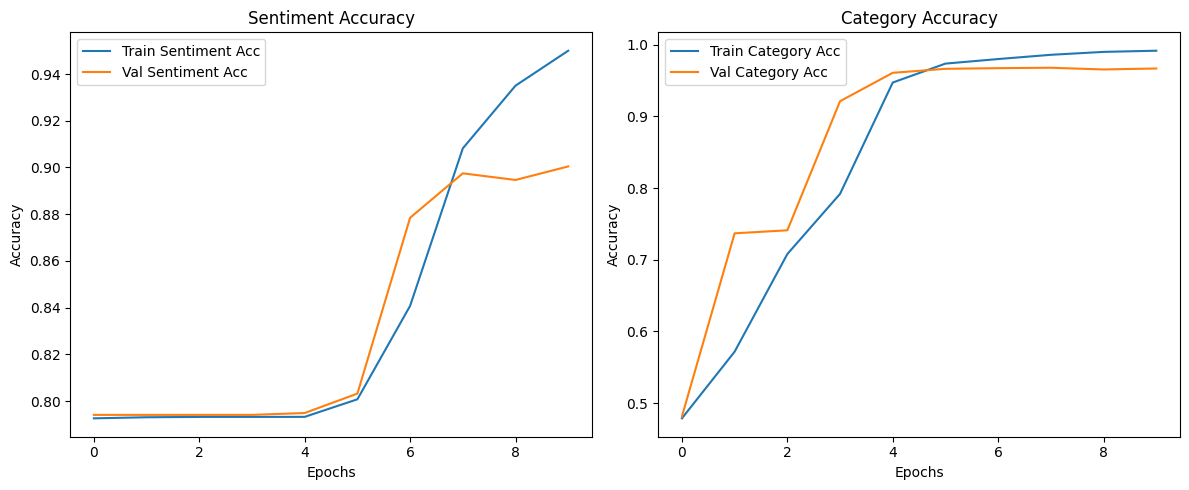

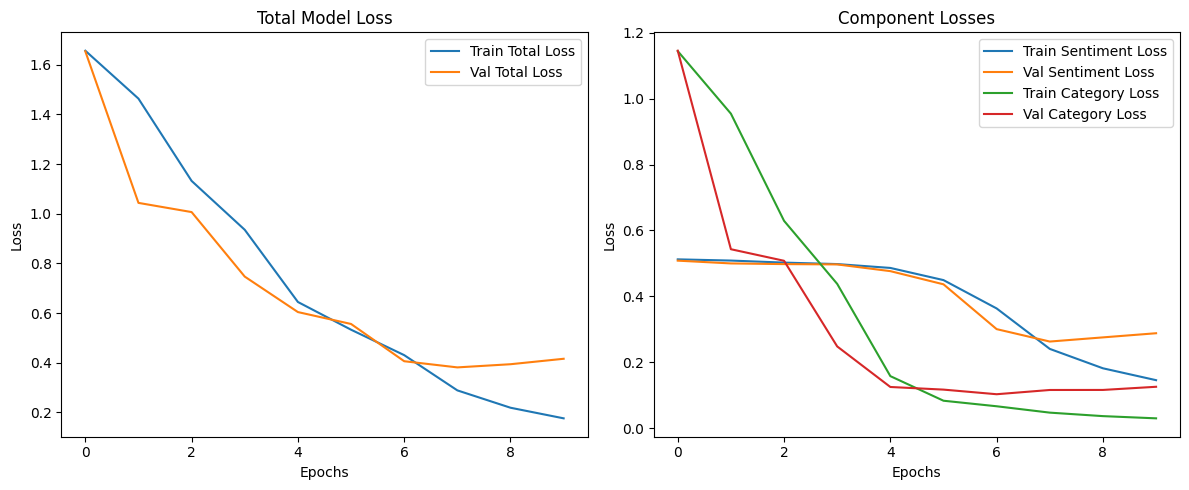


Saving model and artifacts...
Created directory: /content/sentiment_model_output/
Model saved successfully to /content/sentiment_model_output/sentiment_category_model.keras
Tokenizer saved successfully to /content/sentiment_model_output/tokenizer.pickle
Category mapping saved successfully to /content/sentiment_model_output/category_mapping.pickle

--- Modeling Script Finished ---


In [10]:
# --- Evaluate the Model ---
print("\nEvaluating the model on the test set...")

test_results = model.evaluate(
    X_test,
    {'sentiment_output': y_test_sentiment, 'category_output': y_test_category},
    verbose=1
)

# Keras evaluate returns: [total_loss, sentiment_loss, category_loss, sentiment_acc, category_acc]
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Sentiment Loss: {test_results[1]:.4f}")
print(f"Test Category Loss: {test_results[2]:.4f}")
print(f"Test Sentiment Accuracy: {test_results[3] * 100:.2f}%")
print(f"Test Category Accuracy: {test_results[4] * 100:.2f}%")


# --- Plot Training History ---
print("\nPlotting training history...")

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot Sentiment Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['sentiment_output_accuracy'], label='Train Sentiment Acc')
    plt.plot(history.history['val_sentiment_output_accuracy'], label='Val Sentiment Acc')
    plt.title('Sentiment Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Category Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['category_output_accuracy'], label='Train Category Acc')
    plt.plot(history.history['val_category_output_accuracy'], label='Val Category Acc')
    plt.title('Category Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    # Plot Total Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Total Loss')
    plt.plot(history.history['val_loss'], label='Val Total Loss')
    plt.title('Total Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # You can also plot individual losses if needed
    plt.subplot(1, 2, 2)
    plt.plot(history.history.get('sentiment_output_loss', []), label='Train Sentiment Loss') # Use .get for safety
    plt.plot(history.history.get('val_sentiment_output_loss', []), label='Val Sentiment Loss')
    plt.plot(history.history.get('category_output_loss', []), label='Train Category Loss')
    plt.plot(history.history.get('val_category_output_loss', []), label='Val Category Loss')
    plt.title('Component Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()


    plt.tight_layout()
    plt.show()

plot_history(history)


# --- Save Model and Artifacts ---
print("\nSaving model and artifacts...")

# Define save paths
save_dir = "/content/sentiment_model_output/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory: {save_dir}")

model_save_path = os.path.join(save_dir, 'sentiment_category_model.keras')
tokenizer_save_path = os.path.join(save_dir, 'tokenizer.pickle')
mapping_save_path = os.path.join(save_dir, 'category_mapping.pickle')

try:
    # Save the trained model (using the .keras format)
    model.save(model_save_path)
    print(f"Model saved successfully to {model_save_path}")

    # Save the tokenizer
    with open(tokenizer_save_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Tokenizer saved successfully to {tokenizer_save_path}")

    # Save the category mapping
    with open(mapping_save_path, 'wb') as handle:
        pickle.dump(category_mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Category mapping saved successfully to {mapping_save_path}")

except Exception as e:
    print(f"Error saving artifacts: {e}")

print("\n--- Modeling Script Finished ---")